# Machine Learning Nanodegree

## Transfer Learning for Image Classification

## Capstone Project: Write an Algorithm to Classify Plant Seedlings


### Motivation 

In this notebook, I will develop an algorithm that classifies plant seedlings into one of twelve categories. This project is inspired by the Kaggle Competition entitled [Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification). Kaggle community members are challenged to develop algorithms that categorize images of plant seedlings into one of twelve classes. Some classes correspond to valuable crops and the rest correspond to (invaluable) weeds, which compete with crops for the same agricultural resources. If weeds are identified at an early growth stage—when they are seedlings—they can be physically removed, which then gives crops increased chances of prospering since they will not need to compete with the weeds for life-sustaining resources. Consequently, an effective image classifier installed on a smart phone can help farmers keep their plots (mostly) free of weeds, perhaps ultimately leading to increased crop yields.

![Sample Plant Output](images/0bdaf1d8f.png)

### Project Outline

The notebook is divided into separate steps. The links below are useful for navigating the notebook.

* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Data Processing
* [Step 3](#step3): Benchmark Model: a simple ConvNet made from scratch
* [Step 4](#step4): Transfer Learning with VGG19 to develop a ConvNet.
* [Step 5](#step5): Final Model Evaluation
* [Step 6](#step6): Using the solution model with an independent set of plant seedlings images
* [Appendix](#Appendix): Original Implementation

<a id='step1'></a>
## Step 1: Import Datasets

### Import Plant Dataset

In the code cell below, the full dataset of plant images is imported. The data set is rather small having only 4,750 images in total for 12 classes.  The names of these plant classes are displayed as well. 

The following variables were used to store training, validation, and test data.
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
import keras- `plant_names` - list of string-valued plant seedlings names for translating labels

In [1]:
import sys
from importlib import reload
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# Add user-defined functions to path
sys.path.insert(0, 'auxiliary_functions')

# define function to load the image data
def load_dataset(path, numClasses = 12):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), numClasses)
    return plant_files, plant_targets

# load the data
numPlantClasses = 12
plant_files, plant_targets = load_dataset('plantImages/fullDataSet/train/', numPlantClasses)

# load list of plant names
plant_names = [item[30:-1] for item in sorted(glob("plantImages/fullDataSet/train/*/"))]

# Print basic statistics about the data set
print('There are %d total plant categories.' % len(plant_names))
print('There are %d plant images.' % len(plant_files))
print('The plant names are: ')
print(plant_names)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 12 total plant categories.
There are 4750 plant images.
The plant names are: 
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


<a id='step2'></a>
## Step 2: Data Processing

### Remove outliers manually
A comprehensive review of the plant images reveals that some should be excluded from this project. Some images are too blurry to warrant a realistic categorization, while others do not even contain a plant. The images that will be removed from the project are listed in the code cell below.

In [2]:
# After manual assessment of image quality, these images were deemed inadequate for reliable use in this project.

def remove_outliers(plantFiles, targets):
    ''' Removes images that may degrade training. '''
    
    # Folder containing all images
    parentFolder = 'plantImages/fullDataSet/train'
        
    # The first 3 photos definitely do NOT contain the plant seedling or portion thereof.
    # The remaining photos are blurry enough to warrant removal.
    files2remove =     {'CommonChickweed': ['145b9d73c'],
                        
                        'Loose Silky-bent': ['e26600777'],
                        
                        'Sugar beet':['108770d27'],
                        
                        'Common wheat': ['0ec23ca76', '01a2ae45e', '1a9a859c9', '1a5243aa7',
                                         '2d59da822', '2e7881f74', '6e083d6ff', '8d664b2b6',
                                         '9bcfd14d6', '9efa077b7', '11b88da7c', '23c21923f',
                                         '060e8f499', '68c176337', '71c7dd2a2', '75d126b6e',
                                         '93b577009', '975d39600', '2163a30d4', '1478bcfcd',
                                         '2463a30d4', '9933db289', '872174e0f', 'a04fbc0cd',
                                         'a9bda6650', 'a300eb8b2', 'aea5d6bb9', 'ca5707e7b',
                                         'cf0197941', 'd174ffbad', 'e475abfde', 'ebddbe41a'],

                        'Loose Silky-bent': ['6c4d469c8', '972c2c8f7', 'f6439330f', 'fe944dee4', 'ff1f224a5'],
                        
                        'Maize':        ['0f16cf10a', '3cb4f2c65','4f6b0dc39', '59f972ef4', 
                                         '69f06fcbc', '269a34bb9', '0419f5bbc', '822d1163b', 
                                         '5675e608c'],
                        
                        'Scentless Mayweed': ['31bfdd75e', '6132624ad', 'ce3bee65a', 'e4f5d3cf6']
                       }
    
    # Loop through the dictionary and remove the files
    for key, x in files2remove.items():
        for digits in x:
            #file_to_exclude = parentFolder + '\\' + key + '\\' + digits + '.png'  #syntax for running on Windows
            file_to_exclude = parentFolder + '/' + key + '/' + digits + '.png'     #syntax for running on Linux
            itemindex = np.where(plantFiles == file_to_exclude)
            #print(file_to_exclude)
            #print("")
            plantFiles = np.delete(plantFiles, itemindex)
            targets = np.delete(targets, itemindex, axis = 0)
    return plantFiles, targets

In [3]:
plant_files, plant_targets = remove_outliers(plant_files, plant_targets)

To confirm that the images were excluded from the data set, print their size / shape:

In [4]:
print("Shape of images is ", plant_files.shape, " and shape of targets data is ", plant_targets.shape)

Shape of images is  (4701,)  and shape of targets data is  (4701, 12)


### Split the Images into Model Development and Test Sets
The data will be split into two main groups: 80% for model development and 20% for final evaluation. The set for model development will be further subdivided into a training and validation set.

In [5]:
from sklearn.model_selection import train_test_split

# Split plant_files into train_files, valid_files, and test_files. Write them to file
randState = 0  # for reproducibility
alltrain_files, test_files, alltrain_targets, test_targets = train_test_split(
                                                                              plant_files, 
                                                                              plant_targets, 
                                                                              test_size = 0.20, 
                                                                              random_state = randState,
                                                                              stratify = plant_targets)
# Remove one of the test files to have an even number
test_files = test_files[1:]
test_targets = test_targets[1:]

# Print basic statistics about the training and test sets
print('There are %d images for training and validation.' % len(alltrain_files))
print('There are %d images for testing.' % len(test_files))

There are 3760 images for training and validation.
There are 940 images for testing.


### Further split the Model Development Set into 'Train' and 'Validation'
The data are split so that 60% are used for training, 20% for validating hyperparameter optimization, and 20% for final testing after all parameters have been chosen (using the combined training+validation set).

In [6]:
# Split training into 'train' and 'validation'
train_files, valid_files, train_targets, valid_targets = train_test_split(
                                                                          alltrain_files, 
                                                                          alltrain_targets, 
                                                                          test_size = 0.25, 
                                                                          random_state = randState,
                                                                          stratify = alltrain_targets)

# Print basic statistics about the training and test sets
print('There are %d images for training.' % len(train_files))
print('There are %d images for validation.' % len(valid_files))
print('There are %d images for testing.' % len(test_files))

There are 2820 images for training.
There are 940 images for validation.
There are 940 images for testing.


### One Hot Encode the Plant Classes

In [7]:
# Generate Identity matrix for one-hot encoding of classes
plantCategories = np.zeros((numPlantClasses, numPlantClasses))
for row in range(0,numPlantClasses):
    plantCategories[row][row] = 1.

# Print the one-hot encodings    
print(plantCategories)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Visualize the class distribution after discarding poor quality images
The distribution of the image classes is displayed below. In subsequent charts, the distribution of the training, validation, and testing sets are also visualized to confirm that the class distribution of the full data set is approximately preserved within those subsets. A quick glance at the bar charts confirms that the distribution has in fact been preserved.

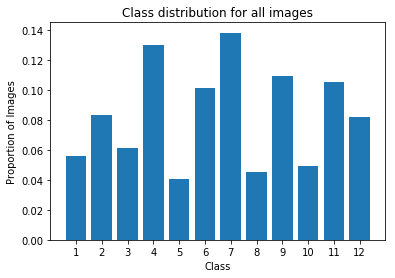

In [8]:
from IPython.display import display, Image
from viz import create_bar_chart
import numpy as np

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

create_bar_chart(plant_targets, plantCategories, titleString = 'Class distribution for all images')

### Class Distribution of Train Set

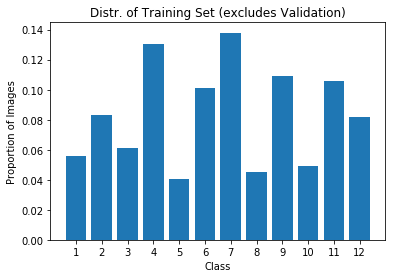

In [9]:
create_bar_chart(train_targets, plantCategories, titleString = 'Distr. of Training Set (excludes Validation)')

### Class Distribution of Validation Set

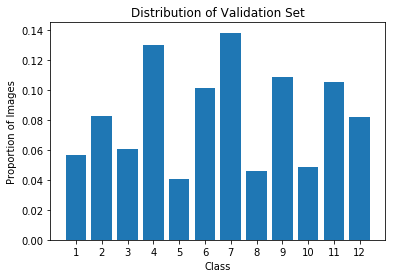

In [10]:
create_bar_chart(valid_targets, plantCategories, titleString = 'Distribution of Validation Set')

### Class Distribution of Test Set

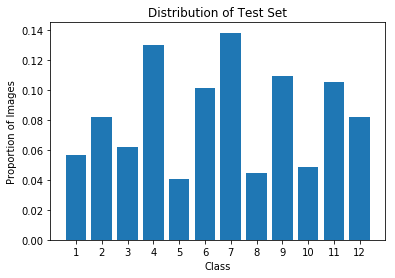

In [11]:
create_bar_chart(test_targets, plantCategories, titleString = 'Distribution of Test Set')

### Image Pre-processing

In this section the images are converted to 4-D tensors. The tensors are helpful for machine learning with Keras.

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

# These functions are borrowed from the following Udacity repo:
# https://github.com/udacity/dog-project/blob/master/dog_app.ipynb
def path_to_tensor(img_path, targetImageSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(targetImageSize, targetImageSize))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, targetImageSize):
    list_of_tensors = [path_to_tensor(img_path, targetImageSize) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Scaling and conversion to Tensors

The images are re-scaled is done in the following way: every pixel in every image is divided by 255 as a way to standardize the pixel values. 

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

NORMALIZATION_FACTOR = 255
plantsImageSize = 224

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR
valid_tensors = paths_to_tensor(valid_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR
test_tensors = paths_to_tensor(test_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR

100%|██████████| 940/940 [00:10<00:00, 91.39it/s] 


---
<a id='step3'></a>
## Step 3: Benchmark Model: a simple ConvNet made from scratch



### Create a directory for saving all models

In [14]:
import os, errno

directory = 'saved_models/'

try:
    os.makedirs(directory)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

### Compile and Train Benchmark CNN

In this section, a convolutional neural network is trined from scratch. The model takes inspiration from the VGG16/VGG19 models in that it consists of alternating blocks containing 2D convolutions and max pooling. The final layers are densely connected. This model also utilizes drop-out in order to reduce the overfitting. It will also not be trained on ImageNet data, which is an option for loading  VGG16 / VGG19 CNNs. The benchmark model is compiled and trained in the code cells below. Model checkpointing is used to save the model that attains the best validation loss. This benchmark CNN is smaller than VGG16 / VGG19 but it is a realistic and quite adequate. The model achieves an F1-score of 0.75.

#### Import Deep Learning Libraries, Sklearn Functions, User Defined Functions

In [15]:
# Load deep learning libraries from Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from modelGen import create_benchmark_CNN
from project_metrics import Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from viz import plot_model_acc_loss

# Extends the f1_score to tensor inputs
from project_metrics import microaveraged_f1score
from predictions import predict_with_tensors

# Import user-defined class that computes the f1-score after each epoch
thisProjectsMetrics = Metrics()

#### Create benchmark model. See 'modelGen.py' for architecture

In [16]:
benchmark = create_benchmark_CNN(plantsImageSize = 224, drop_outA = 0.1, drop_outB = 0.2, neurons = 500)
benchmark.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
__________

#### Fit the benchmark model

Train on 2820 samples, validate on 940 samples
Epoch 1/15
2820/2820 [==============================] - 20s 7ms/step - loss: 1.8522 - acc: 0.3610 - val_loss: 1.4100 - val_acc: 0.4787
— val_f1: 0.47872340425531923

Epoch 00001: val_loss improved from inf to 1.41003, saving model to saved_models/weights.redo.best.from_scratch.hdf5
Epoch 2/15
2820/2820 [==============================] - 19s 7ms/step - loss: 1.1092 - acc: 0.6220 - val_loss: 1.0864 - val_acc: 0.6500
— val_f1: 0.65

Epoch 00002: val_loss improved from 1.41003 to 1.08637, saving model to saved_models/weights.redo.best.from_scratch.hdf5
Epoch 3/15
2820/2820 [==============================] - 19s 7ms/step - loss: 0.6913 - acc: 0.7578 - val_loss: 0.8436 - val_acc: 0.7074
— val_f1: 0.7074468085106383

Epoch 00003: val_loss improved from 1.08637 to 0.84358, saving model to saved_models/weights.redo.best.from_scratch.hdf5
Epoch 4/15
2820/2820 [==============================] - 19s 7ms/step - loss: 0.4739 - acc: 0.8266 - val_loss: 0.

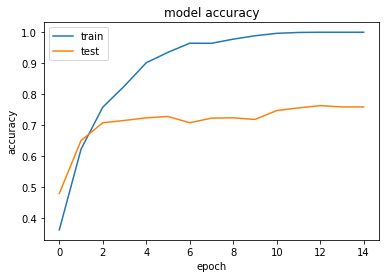

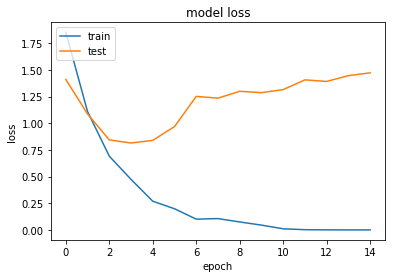

In [28]:
reTrainBenchmark = False

# Define number of epochs and batch size
nEpochs = 15
batchSize = 20

if reTrainBenchmark:
    # Define checkpointer
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                                   verbose=1, 
                                   save_best_only=True)

    # Train the model
    benchmarkHistory = benchmark.fit(train_tensors, train_targets, 
                                     validation_data = (valid_tensors, valid_targets),
                                     epochs = nEpochs,
                                     batch_size = batchSize,
                                     callbacks = [thisProjectsMetrics, checkpointer],
                                     verbose = 1)
    
    # Plot the Training History
    plot_model_acc_loss(benchmarkHistory)

### Test the Benchmark Model

The benchmark CNN is evaluated on the specially designated test dataset of plant seedlings images. The F1-score on the test set is printed below.

In [19]:
# Load the weights yielding the best validation loss
benchmark.load_weights('saved_models/weights.best.from_scratch.hdf5')

# Make predictions with Test Set
predictionsWithBenchmark = predict_with_tensors(benchmark, test_tensors)

# Determine F1-score
F1ScoreBenchmark = microaveraged_f1score(test_targets, predictionsWithBenchmark)

# Print F1-score to console
print("This F1-score for this model is ", F1ScoreBenchmark)

This F1-score for this model is  0.7510638297872341


---
<a id='step4'></a>
## Step 4: Transfer Learning with VGG19 to develop a ConvNet.

In this section transfer learning is used to train a CNN. The goal is to take advantage of VGG19, a pre-trained CNN that has already been trained on ImageNet, a standard computer vision image dataset that contains images of both natural and man-made objects. None of the categories of the ImageNet database include plants, so this application of transfer learning will rely on the general features that VGG19 has already learned from the ImageNet database.

### Preprocess the Image Data

In [22]:
from keras.applications.vgg19 import preprocess_input

def preprocess_images(data_files, inputImageSize = 224):
    ''' Preprocess the image data for VGG19 model '''
    
    # Convert Images to Tensors and pass through 'preprocess_input' function
    preprocessedData = preprocess_input(paths_to_tensor(data_files, inputImageSize))
    return preprocessedData

In [24]:
# Preprocess the image data
trainData = preprocess_images(train_files, plantsImageSize)
validData = preprocess_images(valid_files, plantsImageSize)
testData = preprocess_images(test_files, plantsImageSize)

100%|██████████| 940/940 [00:10<00:00, 90.73it/s] 


#### Create combined VGG19 + top-model ConvNet

In [21]:
import pickle
from keras.optimizers import RMSprop
from keras import optimizers
from modelGen import create_top_model, aggregated_model

reTrainTopModel = False
nEpochs = 15

# Set Parameters for model development
layersToKeep = 22                # [4, 7, 12, 17, -1]
learnRate = 0.0005               # [0.0001, 0.0005, 0.001, 0.005]
nDenseNeuron = 128               # [64, 128]
dropout = 0.10                   # [0.10, 0.20]

# Create model: VGG19 + densely connected "top model"
whichOptimizer = 0               # 0 to train top model
model = aggregated_model(plantsImageSize,layersToKeep,layersToKeep,learnRate,nDenseNeuron,dropout,whichOptimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### The combined VGG19 (all layers frozen) + "top model" is trained here

In [44]:
params_string = 'LR_0005_neurons_' + str(nDenseNeuron) + '_drop_' + str(int(dropout*100))
filepath_best_topLayers = 'saved_models/weights.best.topLayers_' + params_string + '.hdf5'

if reTrainTopModel:
    checkpointer = ModelCheckpoint(filepath = filepath_best_topLayers, verbose=1, save_best_only=True)

    # Train the (top) model
    topModel_history = model.fit(trainData, train_targets,
                                 validation_data = (validData, valid_targets),
                                 epochs = nEpochs, 
                                 batch_size = batchSize, 
                                 callbacks = [thisProjectsMetrics, checkpointer], 
                                 verbose=1)
    
    # Plot the training history
    plot_model_acc_loss(topModel_history)

### Fine Tune the Aggregate ConvNet

In [45]:
fineTuneModel = False
vggFreeze = [4, 7, 12, 17, 22]

if fineTuneModel:

    for VggLayersToFreeze in vggFreeze:

        # Load weights from the top model
        whichOptimizer = 1
        finalModel = aggregated_model(plantsImageSize,layersToKeep,VggLayersToFreeze,learnRate,nDenseNeuron,dropout,whichOptimizer)
        finalModel.load_weights(filepath_best_topLayers)

        # Fine tune model
        params_string = 'LR_0005_neurons_'+str(nDenseNeuron)+'_drop_'+str(int(dropout*100))+'_freeze_'+str(VggLayersToFreeze)
        filepath_best_final_model = 'saved_models/weights.best.finalModel_' + params_string + '.hdf5'

        checkpointer = ModelCheckpoint(filepath = filepath_best_final_model, verbose=1, save_best_only=True)

        finalModel_history = finalModel.fit(trainData, 
                                            train_targets,
                                            validation_data = (validData, valid_targets),
                                            epochs = nEpochs, 
                                            batch_size = batchSize, 
                                            callbacks = [thisProjectsMetrics, checkpointer], 
                                            verbose=1)

        # Save training history
        histFilename = 'saved_models/trainHistoryDict_' + params_string
        with open(histFilename, 'wb') as file_pi:
            pickle.dump(finalModel_history.history, file_pi)

Train on 2820 samples, validate on 940 samples
Epoch 1/15
2820/2820 [==============================] - 78s 28ms/step - loss: 0.7078 - acc: 0.8230 - val_loss: 0.6291 - val_acc: 0.8191
— val_f1: 0.8191489361702128

Epoch 00001: val_loss improved from inf to 0.62907, saving model to saved_models/weights.best.finalModel_LR_0005_neurons_128_drop_10_freeze_12.hdf5
Epoch 2/15
2820/2820 [==============================] - 76s 27ms/step - loss: 0.2784 - acc: 0.9142 - val_loss: 0.5790 - val_acc: 0.8404
— val_f1: 0.8404255319148938

Epoch 00002: val_loss improved from 0.62907 to 0.57900, saving model to saved_models/weights.best.finalModel_LR_0005_neurons_128_drop_10_freeze_12.hdf5
Epoch 3/15
2820/2820 [==============================] - 76s 27ms/step - loss: 0.1161 - acc: 0.9617 - val_loss: 0.5699 - val_acc: 0.8596
— val_f1: 0.8595744680851064

Epoch 00003: val_loss improved from 0.57900 to 0.56993, saving model to saved_models/weights.best.finalModel_LR_0005_neurons_128_drop_10_freeze_12.hdf5
Epo

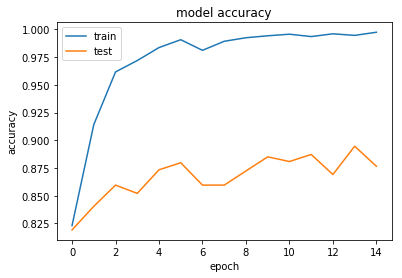

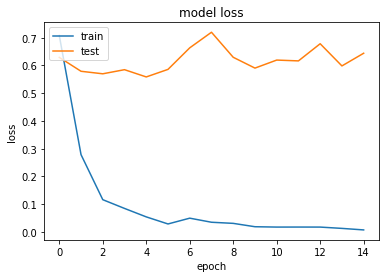

In [46]:
# Plot training history
plot_model_acc_loss(finalModel_history)

<a id='step5'></a>
## Step 5: Final Model Evaluation

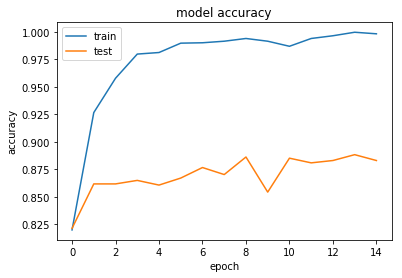

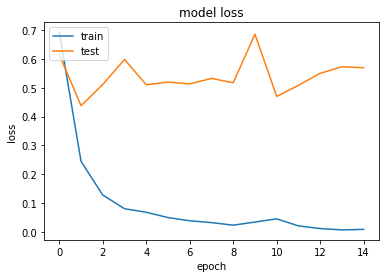

In [20]:
# Plot training history
from viz import plot_saved_model_acc_loss

filename_best_finalModelHistory = 'saved_models/trainHistoryDict_LR_0005_neurons_128_drop_10_freeze_12'
pickle_in = open(filename_best_finalModelHistory,"rb")
best_finalModelHistory = pickle.load(pickle_in)
plot_saved_model_acc_loss(best_finalModelHistory)

In [25]:
# Load the best model
whichOptimizer = 1
layersToKeep = 22
VggLayersToFreeze = 12
learnRate = 0.0005
nDenseNeuron = 128
dropout = 0.10
bestfinalModel = aggregated_model(plantsImageSize,layersToKeep,VggLayersToFreeze,learnRate,nDenseNeuron,dropout,whichOptimizer)

filename_best_topLayers = './saved_models/weights.best.finalModel_LR_0005_neuron_128_drop_10_freeze_12.hdf5'
bestfinalModel.load_weights(filename_best_topLayers)

# Make Predictions
finalPredictions = predict_with_tensors(bestfinalModel, testData)

# Determine F1-score
modelF1Score = microaveraged_f1score(test_targets, finalPredictions)

# Print to console
print("This model's F1-score is ", modelF1Score)

This model's F1-score is  0.8531914893617021


<a id='step6'></a>
## Step 6: Using the solution model with an independent set of plant seedlings images

In this section, the solution model is used to make predictions with images of plant seedlings that were gathered via a web search. These images include Maize, Wheat, Shepherd's Purse, and Scentless Mayweed.

100%|██████████| 5/5 [00:00<00:00, 124.59it/s]


There are 5 images to analyze.

Reading file non_kaggle_images_for_prediction/31859rhizoctonia.jpg


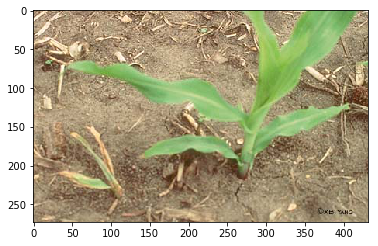

The model predicts 8 :Scentless Mayweed
***************************************************************************

Reading file non_kaggle_images_for_prediction/shprdspursesdling150.jpg


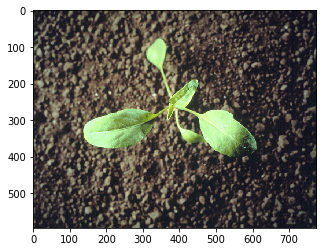

The model predicts 3 :Common Chickweed
***************************************************************************

Reading file non_kaggle_images_for_prediction/sheperdsPurseSeedling.jpg


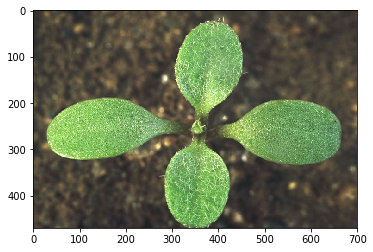

The model predicts 5 :Fat Hen
***************************************************************************

Reading file non_kaggle_images_for_prediction/Broom-corn-millet-seedling.jpg


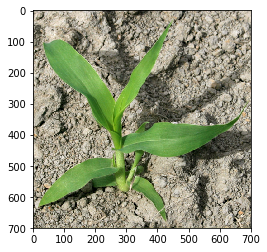

The model predicts 7 :Maize
***************************************************************************

Reading file non_kaggle_images_for_prediction/scentless_mayweed_2.png


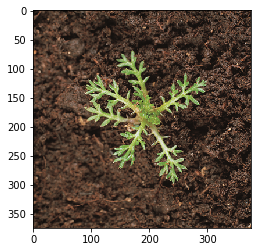

The model predicts 8 :Scentless Mayweed
***************************************************************************
All finished analyzing images!


In [29]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

newImageFiles = np.array(glob("non_kaggle_images_for_prediction/*"))
newImageTensors = preprocess_images(newImageFiles, plantsImageSize)
predictedProbabilities = predict_with_tensors(bestfinalModel, newImageTensors)

print('There are %d images to analyze.' % len(newImageFiles))

for idx, imageFile in enumerate(newImageFiles):
    print('')
    print('Reading file', newImageFiles[idx])
    img = mpimg.imread(newImageFiles[idx])
    imgplot = plt.imshow(img)
    plt.show()
    predictionIndex = np.argmax(predictedProbabilities[idx])
    print('The model predicts ' + str(predictionIndex) + ' :' + plant_names[predictionIndex])
    print('***************************************************************************')

print('All finished analyzing images!')

<a id='Appendix'></a>
## Appendix: Original Implementation

The original idea for this project involved completely removing layers from the end of the VGG19 network, adding the top model to the remnant architecture, and training the network with the data. Unfortunately, doing so lead to very poor performance despite my best efforts to try a variety of parameter values. This section demonstrates how the implementation was performed, with quantitative results obtained by using one set of parameter values.

In [52]:
vggLayerstoKeep = 17
nLayersToFreeze = vggLayerstoKeep
learnRate = 0.000001
numDenseNeurons = 128
dropout_rate = 0.20
optim = 0
truncvgg19 = aggregated_model(plantsImageSize,vggLayerstoKeep,nLayersToFreeze,learnRate,numDenseNeurons,dropout_rate,optim)
truncvgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Train on 2820 samples, validate on 940 samples
Epoch 1/15
2820/2820 [==============================] - 51s 18ms/step - loss: 14.1005 - acc: 0.1206 - val_loss: 14.1365 - val_acc: 0.1213
— val_f1: 0.12127659574468085
Epoch 2/15
2820/2820 [==============================] - 50s 18ms/step - loss: 14.0183 - acc: 0.1270 - val_loss: 14.0712 - val_acc: 0.1223
— val_f1: 0.12234042553191489
Epoch 3/15
2820/2820 [==============================] - 50s 18ms/step - loss: 13.9683 - acc: 0.1294 - val_loss: 13.9028 - val_acc: 0.1330
— val_f1: 0.13297872340425532
Epoch 4/15
2820/2820 [==============================] - 50s 18ms/step - loss: 13.8441 - acc: 0.1376 - val_loss: 13.8680 - val_acc: 0.1330
— val_f1: 0.13297872340425532
Epoch 5/15
2820/2820 [==============================] - 50s 18ms/step - loss: 13.8143 - acc: 0.1397 - val_loss: 13.9466 - val_acc: 0.1287
— val_f1: 0.12872340425531914
Epoch 6/15
2820/2820 [==============================] - 50s 18ms/step - loss: 13.7314 - acc: 0.1450 - val_loss: 1

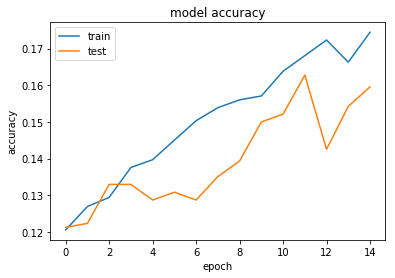

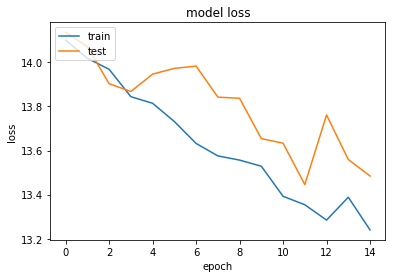

In [53]:
batchSize = 20
trainTruncTop = True

if trainTruncTop:
    #checkpointer = ModelCheckpoint(filepath = filepath_best_topLayers, verbose=1, save_best_only=True)

    # Train the (top) model
    topModel_history = truncvgg19.fit(trainData, train_targets,
                                      validation_data = (validData, valid_targets),
                                      epochs = nEpochs, 
                                      batch_size = batchSize, 
                                      callbacks = [thisProjectsMetrics], 
                                      verbose=1)
    
    # Plot the training history
    plot_model_acc_loss(topModel_history)

During 15 epochs of training the best results were a validation loss of 13.45 and a validation F1-score of 0.16.